# Machine Learning 

**Classifier #3** --> MHW categories

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

from imblearn.over_sampling import RandomOverSampler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load dataset

In [3]:
def numeric_columns(df):
    numeric_cols = []
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            numeric_cols.append(col)
    return numeric_cols

# Load dataset
df = pd.read_csv("/Users/annaolsen/Desktop/Speciale/KODEN/data/TARA_mhws_Dash_3.csv")

df['MHW_category'].fillna("None", inplace=True)

print(f"Shape of dataset: {df.shape}")
# print(df.columns)

numeric_cols = numeric_columns(df)

df_num = df[numeric_cols]

print(f"Shape of dataset with numerical features: {df_num.shape}")
# print(df_num.columns)


Shape of dataset: (4474, 79)
Shape of dataset with numerical features: (4474, 57)


### Classifier #3 - MHW categories (None, Moderate, Strong+)

In [56]:
df = pd.read_csv("/Users/annaolsen/Desktop/Speciale/KODEN/data/TARA_mhws_Dash_3.csv")

df['MHW_category'].fillna("None", inplace=True)

# print(df['MHW_category'].value_counts())

# Replace values in 'count'
category_replace = {
    'None': '.None',
    'Moderate': 'Moderate',
    'Strong': 'Strong+',
    'Severe': 'Strong+',
}

# Apply replacements to 'MHWs count'
df['MHW_category'] = df['MHW_category'].replace(category_replace)

print(df['MHW_category'].value_counts())


# Shuffle the DataFrame
shuffled_df = shuffle(df, random_state=42)


y = shuffled_df['MHW_category']

numeric_cols = numeric_columns(shuffled_df)

X = shuffled_df[numeric_cols]

# Separate features (X) and labels (y) after shuffling
X = X.drop(['MHW_count', 'Year'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(f"Input variables (X): \n{X_train.columns}")

clf = DecisionTreeClassifier(random_state=79, 
                             class_weight='balanced',
                             criterion='entropy',
                             max_depth=8, min_samples_split=60,
                             min_samples_leaf=40,
                             )

# Define KFold with shuffle=True
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation with shuffled data
cv_scores = cross_val_score(clf, X_train, y_train, cv=kf)

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Train Decision Tree Classifier on training data
clf.fit(X_train, y_train)

# Get the class names in the correct order
class_names = clf.classes_

# Model Evaluation on test data
y_pred = clf.predict(X_test)
# print(classification_report(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=np.unique(y)))
# plt.figure(figsize=(45,22))
# plot_tree(clf, filled=True, rounded=True, feature_names=X.columns,
#           class_names=class_names, fontsize=16, precision=1,
#           impurity=True, label='all')
# plt.show()

MHW_category
.None       3528
Moderate     701
Strong+      245
Name: count, dtype: int64
(3131, 55) (1343, 55) (3131,) (1343,)
Input variables (X): 
Index(['Ammonium', 'Ammonium std', 'Chl a', 'Depth bathy', 'Depth bot',
       'Depth top', 'Functional evenness', 'Functional richness', 'Iron',
       'Iron std', 'Latitude', 'Longitude', 'Max Lyapunov Exp', 'NPP Carbon',
       'NPP Carbon 30', 'Nitrate', 'Nitrate std', 'Nitrite', 'Nitrite std',
       'Okubo-Weiss', 'PIC', 'POC', 'Phosphate max', 'Phosphate med',
       'Phosphate min', 'Radiation', 'Radiation 30', 'Radiation 8.1',
       'Radiation 8.2', 'Residence time', 'SILVA_Chao', 'SILVA_Shannon',
       'SILVA_ace', 'SILVA_func_diversity', 'SILVA_species_rich', 'SST',
       'Sea ice conc', 'Sea ice free days', 'Sea ice free end',
       'Sea ice free start', 'SS Chl a', 'SS Fluorescence',
       'SS Quantum Fluorescence', 'SST Grad', 'Shannon_Darwin_mean_all',
       'Shannon_Darwin_mean_grp', 'Shannon_Darwin_month_all',
     

#### ROC Curves

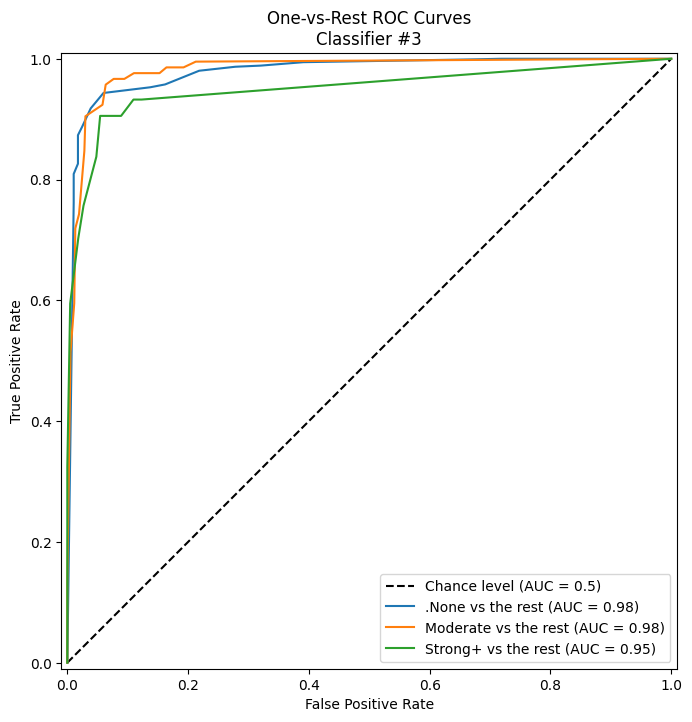

In [57]:
y_score = clf.predict_proba(X_test)

# Binarize the labels for multi-class roc auc calculation
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the chance level
ax.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Chance level (AUC = 0.5)')

# Iterate over each class and plot the ROC curve
for class_of_interest in label_binarizer.classes_:
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        ax=ax,
    )

# Set plot labels and title
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("One-vs-Rest ROC Curves\nClassifier #3")
ax.legend(loc="best")

plt.savefig('/Users/annaolsen/Desktop/Speciale/KODEN/roc_classifier3.png', bbox_inches='tight', dpi=200)

plt.show()


#### Confusion Matrix

[[940  62  57]
 [  5 201   4]
 [  2  10  62]]


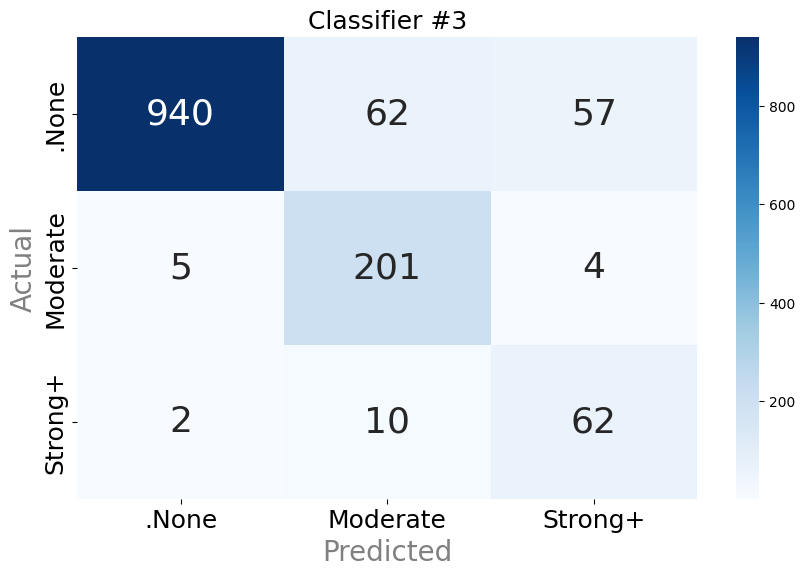

In [58]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=clf.classes_, yticklabels=clf.classes_,
            annot_kws={"size": 26})

plt.xlabel('Predicted', fontsize=20, color='grey')  
plt.ylabel('Actual', fontsize=20, color='grey') 
plt.title('Classifier #3', fontsize=18) 

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.savefig('/Users/annaolsen/Desktop/Speciale/KODEN/cm_classifier3.png', bbox_inches='tight', dpi=200)

plt.show()


### GridSearchCV

In [51]:
df = pd.read_csv("/Users/annaolsen/Desktop/Speciale/KODEN/data/TARA_mhws_Dash_3.csv")

df['MHW_category'].fillna("None", inplace=True)

# print(df['MHW_category'].value_counts())

# Replace values in 'MHW_category'
category_replace = {
    'None': 'None',
    'Moderate': 'Moderate',
    'Strong': 'Strong+',
    'Severe': 'Strong+',
}

# Apply replacements to 'MHW_category'
df['MHW_category'] = df['MHW_category'].replace(category_replace)

print(df['MHW_category'].value_counts())

# Shuffle the DataFrame
shuffled_df = shuffle(df, random_state=42)


y = shuffled_df['MHW_category']

numeric_cols = numeric_columns(shuffled_df)

X = shuffled_df[numeric_cols]

# Separate features (X) and labels (y) after shuffling
X = X.drop(['MHW_count', 'Year'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, 
                                                    random_state=72)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(f"Input variables (X): \n{X_train.columns}")

# Define Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=22, class_weight='balanced')

# Define parameter grid for GridSearchCV
param_grid = {
   'max_depth': [7, 8, 9, 10, 11],
    'min_samples_split': [30, 40, 50, 60],
    'min_samples_leaf': [30, 35, 40, 45],
    'criterion': ['entropy', 'gini', 'log_loss'],
    'max_features': [30, 40, 50, None],
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, 
                           scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)


# Get the best estimator from the grid search
best_clf = grid_search.best_estimator_

# Train Decision Tree Classifier on with the best hyperparameters
best_clf.fit(X_train, y_train)

# Get the class names in the correct order
class_names = best_clf.classes_

# Model Evaluation on test data
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Get the best parameters and the corresponding accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)


MHW_category
None        3528
Moderate     701
Strong+      245
Name: count, dtype: int64
(3131, 55) (1343, 55) (3131,) (1343,)
Input variables (X): 
Index(['Ammonium', 'Ammonium std', 'Chl a', 'Depth bathy', 'Depth bot',
       'Depth top', 'Functional evenness', 'Functional richness', 'Iron',
       'Iron std', 'Latitude', 'Longitude', 'Max Lyapunov Exp', 'NPP Carbon',
       'NPP Carbon 30', 'Nitrate', 'Nitrate std', 'Nitrite', 'Nitrite std',
       'Okubo-Weiss', 'PIC', 'POC', 'Phosphate max', 'Phosphate med',
       'Phosphate min', 'Radiation', 'Radiation 30', 'Radiation 8.1',
       'Radiation 8.2', 'Residence time', 'SILVA_Chao', 'SILVA_Shannon',
       'SILVA_ace', 'SILVA_func_diversity', 'SILVA_species_rich', 'SST',
       'Sea ice conc', 'Sea ice free days', 'Sea ice free end',
       'Sea ice free start', 'SS Chl a', 'SS Fluorescence',
       'SS Quantum Fluorescence', 'SST Grad', 'Shannon_Darwin_mean_all',
       'Shannon_Darwin_mean_grp', 'Shannon_Darwin_month_all',
     

In [54]:
# Extract results from grid search
results_df = pd.DataFrame(grid_search.cv_results_)

# Extract parameter names
param_names = list(param_grid.keys())

# Create separate columns for each parameter
for param_name in param_names:
    results_df[param_name] = results_df['params'].apply(lambda x: x[param_name])

# Select relevant columns
score_columns = [col for col in results_df.columns if 'mean_test_' in col]
columns_to_keep = param_names + score_columns

# Sort results by accuracy in descending order
results_df = results_df.sort_values(by=score_columns[0], ascending=False)

results_df = results_df[columns_to_keep]

print(results_df['mean_test_score'].max())

best = results_df[results_df['mean_test_score'] > 0.87]

# print(best)

# Sort the results DataFrame by the specified columns
best = best.sort_values(by=['max_depth', 'min_samples_leaf', 'min_samples_split', 'max_features'], ascending=[True, False, False, True])

print(best[:15])

# Select the top row (combination with the highest values for min_samples_split and min_samples_leaf,
# and the lowest values for max_depth and max_features)
best_combination = best.iloc[0]

print("Best combination:")
print(best_combination)


0.8703277945080534
     max_depth  min_samples_split  min_samples_leaf criterion  max_features  \
755          8                 60                30  log_loss           NaN   
115          8                 60                30   entropy           NaN   
114          8                 50                30   entropy           NaN   
754          8                 50                30  log_loss           NaN   
113          8                 40                30   entropy           NaN   
753          8                 40                30  log_loss           NaN   
752          8                 30                30  log_loss           NaN   
112          8                 30                30   entropy           NaN   
851         10                 60                30  log_loss          40.0   
211         10                 60                30   entropy          40.0   
210         10                 50                30   entropy          40.0   
850         10                 50

### RandomOverSampler

In [26]:
df = pd.read_csv("/Users/annaolsen/Desktop/Speciale/KODEN/data/TARA_mhws_Dash_3.csv")

df['MHW_category'].fillna("None", inplace=True)

# print(df['MHW_category'].value_counts())


# Replace values in 'MHW_category'
category_replace = {
    'None': 'None',
    'Moderate': 'Moderate',
    'Strong': 'Strong+',
    'Severe': 'Strong+',
}

# Apply replacements to 'MHW_category'
df['MHW_category'] = df['MHW_category'].replace(category_replace)

print(df['MHW_category'].value_counts())

# Shuffle the DataFrame
shuffled_df = shuffle(df, random_state=42)


y = shuffled_df['MHW_category']

numeric_cols = numeric_columns(shuffled_df)

X = shuffled_df[numeric_cols]

# Separate features (X) and labels (y) after shuffling
X = X.drop(['MHW_count', 'Year'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, 
                                                    random_state=72)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


# Instantiate RandomOverSampler to balance the classes
ros = RandomOverSampler(random_state=42)

# Apply RandomOverSampler to balance the classes
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print(X_train_resampled.shape, X_test.shape, y_train_resampled.shape, y_test.shape)


# Define Decision Tree Classifier
clf_ros = DecisionTreeClassifier(random_state=22, class_weight='balanced')

# Define parameter grid for GridSearchCV
param_grid = {
   'max_depth': [8, 9, 10, 11, 12, 13],
    'min_samples_split': [20, 30, 40],
    'min_samples_leaf': [15, 20, 25, 30, 35],
    'criterion': ['entropy', 'gini', 'log_loss'],
    'max_features': [30, 40, 50, None],
}


# Perform Grid Search with cross-validation
grid_search_ros = GridSearchCV(estimator=clf_ros, param_grid=param_grid, cv=5, 
                           scoring='accuracy', verbose=1)

grid_search_ros.fit(X_train_resampled, y_train_resampled)


# Get the best estimator from the grid search
best_clf_ros = grid_search_ros.best_estimator_


# Train Decision Tree Classifier on full training data with the best hyperparameters
best_clf_ros.fit(X_train_resampled, y_train_resampled)


# Get the class names in the correct order
class_names = best_clf_ros.classes_


# Model Evaluation on test data
y_pred = best_clf_ros.predict(X_test)
print(classification_report(y_test, y_pred))

# Get the best parameters and the corresponding accuracy
best_params = grid_search_ros.best_params_
best_accuracy = grid_search_ros.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)


MHW_category
None        3528
Moderate     701
Strong       211
Severe        34
Name: count, dtype: int64
MHW_category
None        3528
Moderate     701
Strong+      245
Name: count, dtype: int64
(3131, 56) (1343, 56) (3131,) (1343,)
(7407, 56) (1343, 56) (7407,) (1343,)
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
              precision    recall  f1-score   support

    Moderate       0.17      0.33      0.22       210
        None       0.78      0.50      0.61      1059
     Strong+       0.05      0.16      0.07        74

    accuracy                           0.46      1343
   macro avg       0.33      0.33      0.30      1343
weighted avg       0.65      0.46      0.52      1343

Best Parameters: {'criterion': 'gini', 'max_depth': 13, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 20}
Best Accuracy: 0.6909705573339675


In [31]:
# Extract results from grid search
results_df_ros = pd.DataFrame(grid_search_ros.cv_results_)

# Extract parameter names
param_names = list(param_grid.keys())

# Create separate columns for each parameter
for param_name in param_names:
    results_df_ros[param_name] = results_df_ros['params'].apply(lambda x: x[param_name])

# Select relevant columns
score_columns = [col for col in results_df_ros.columns if 'mean_test_' in col]
columns_to_keep = param_names + score_columns

# Sort results by accuracy in descending order
results_df_ros = results_df_ros.sort_values(by=score_columns[0], ascending=False)

results_df_ros = results_df_ros[columns_to_keep]

print(results_df_ros['mean_test_score'].max())

best = results_df_ros[results_df_ros['mean_test_score'] > 0.688]

# print(best)

# Sort the results DataFrame by the specified columns
best = best.sort_values(by=['max_depth', 'min_samples_leaf', 'min_samples_split', 'max_features'], ascending=[True, False, False, True])

print(best[:10])

# Select the top row (combination with the highest values for min_samples_split and min_samples_leaf,
# and the lowest values for max_depth and max_features)
best_combination = best.iloc[0]

print("Best combination:")
print(best_combination)


0.6909705573339675
      max_depth  min_samples_split  min_samples_leaf criterion  max_features  \
706          13                 30                15      gini           NaN   
1066         13                 30                15  log_loss           NaN   
346          13                 30                15   entropy           NaN   
705          13                 20                15      gini           NaN   
345          13                 20                15   entropy           NaN   
1065         13                 20                15  log_loss           NaN   

      mean_test_score  
706          0.690971  
1066         0.688403  
346          0.688403  
705          0.690971  
345          0.688403  
1065         0.688403  
Best combination:
max_depth                  13
min_samples_split          30
min_samples_leaf           15
criterion                gini
max_features              NaN
mean_test_score      0.690971
Name: 706, dtype: object


### 1000 iterations with different random_state seeds

In [59]:
df = pd.read_csv("/Users/annaolsen/Desktop/Speciale/KODEN/data/TARA_mhws_Dash_3.csv")

df['MHW_category'].fillna("None", inplace=True)

# print(df['MHW_category'].value_counts())

# Replace values in 'MHW_category'
category_replace = {
    'None': 'None',
    'Moderate': 'Moderate',
    'Strong': 'Strong+',
    'Severe': 'Strong+',
}

# Apply replacements to 'MHW_category'
df['MHW_category'] = df['MHW_category'].replace(category_replace)

print(df['MHW_category'].value_counts())


# Set the number of iterations
num_iterations = 1000

# Define lists to store results
results_iter = []

for i in range(num_iterations):

    # Shuffle the DataFrame
    shuffled_df = shuffle(df, random_state=i)

    y = shuffled_df['MHW_category']

    numeric_cols = numeric_columns(shuffled_df)

    X = shuffled_df[numeric_cols]

    # Separate features (X) and labels (y) after shuffling
    X = X.drop(['MHW_count', 'Year'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        stratify=y, 
                                                        random_state=i)

    # Define Decision Tree Classifier with desired hyperparameters
    clf_rs = DecisionTreeClassifier(random_state=i,
                                    class_weight='balanced',
                                    criterion='entropy',
                                    max_depth=8, min_samples_split=60,
                                    min_samples_leaf=40, max_features=None,
                                 )

    # Train Decision Tree Classifier on full training data
    clf_rs.fit(X_train, y_train)

    # Model Evaluation on test data
    y_pred = clf_rs.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Get feature names and their importance
    feature_importance = clf_rs.feature_importances_
    feature_names = X.columns.tolist()

    # Sort features by importance and select top 40
    sorted_features = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)[:40]

    # Append results to the list
    results_iter.append({
        'Iteration': i + 1,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Top Important Features': sorted_features
    })

# Create a DataFrame from the results
results_iter_df = pd.DataFrame(results_iter)

mean_accuracy = results_iter_df['Accuracy'].mean()

print(f"Mean accuracy across 1000 iterations: {mean_accuracy}")


MHW_category
None        3528
Moderate     701
Strong+      245
Name: count, dtype: int64
Mean accuracy across 1000 iterations: 0.8735720670391063


### Feature Importance

In [63]:

def plot_feature_importance(importance_df, title, plot_name, top_n=10, xlim=(0, 0.28)):

    # Sort the DataFrame by importance
    importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False)
    importance_df_sorted = importance_df_sorted.reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df_sorted.iloc[:top_n],
                palette='viridis', hue='Feature', dodge=False, legend=False)
    plt.title(title, fontsize=14)
    plt.xlabel('Importance (%)', fontsize=12)
    plt.ylabel('')
    plt.xlim(xlim)
    
    # Convert importance values to percentages and add numbers beside each bar
    for index, row in importance_df_sorted.iloc[:top_n].iterrows():
        importance_percentage = round(row['Importance'] * 100, 2)
        plt.text(row['Importance'] + 0.004, index, f"{importance_percentage}%",
                 ha='left', va='center')

    plt.savefig(f'/Users/annaolsen/Desktop/Speciale/KODEN/{plot_name}.png', bbox_inches='tight', dpi=200)

    plt.show()


In [61]:
# Calculate the mean importance for each feature across all iterations
all_features = [feat for sublist in results_iter_df['Top Important Features'] for feat in sublist]
mean_importance = {}
for feature, importance in all_features:
    if feature not in mean_importance:
        mean_importance[feature] = 0
    mean_importance[feature] += importance

# Divide the sum by the number of iterations to get the mean importance
num_iterations = len(results_iter_df)
for feature in mean_importance:
    mean_importance[feature] /= num_iterations

print("Mean Top Important Features:")
print(mean_importance)


# Convert mean_importance dictionary to DataFrame
mean_importance_df1 = pd.DataFrame(mean_importance.items(), columns=['Feature', 'Importance'])

# Sort the DataFrame by mean importance values in descending order
mean_importance_df1 = mean_importance_df1.sort_values(by='Importance', ascending=False)

print(mean_importance_df1[:5])


top_30 = mean_importance_df1['Feature'].iloc[:30]
print(top_30.unique())

Mean Top Important Features:
{'Longitude': 0.11438030807148665, 'SS Chl a': 0.04276806153408767, 'POC': 0.14364272726198501, 'Nitrate': 0.09084112153201265, 'Latitude': 0.03922706059038383, 'Ammonium std': 0.028043417489422892, 'SST': 0.02040351612860611, 'Okubo-Weiss': 0.037635121799953465, 'SST Grad': 0.018373318601990162, 'Nitrite': 0.027537163533603165, 'v': 0.07353851309528328, 'Iron': 0.06865411957322211, 'Iron std': 0.0049653024884401065, 'Radiation 8.2': 0.013532803372817696, 'Sunshine duration': 0.026014019456992086, 'Depth bathy': 0.03246688320126484, 'Max Lyapunov Exp': 0.013952931914478259, 'Phosphate med': 0.0017217022374660077, 'TSM': 0.04749527891773755, 'NPP Carbon 30': 7.254313263919462e-18, 'Depth top': 0.00026616620437006024, 'Ammonium': 0.019494864233956886, 'Chl a': 0.008095569307891409, 'Depth bot': 0.000410509602247529, 'Functional evenness': 1.417312009150835e-18, 'Functional richness': 2.1738764748782426e-18, 'NPP Carbon': 1.00673349262762e-06, 'Nitrate std': 0

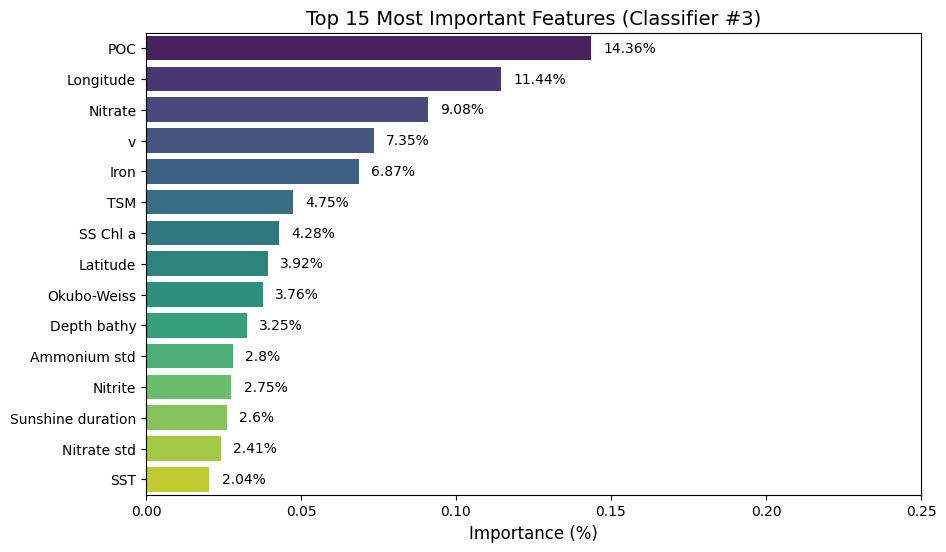

In [64]:
# Plot feature importance for 'MHWs' prediction
plot_feature_importance(mean_importance_df1.iloc[:27],
                        "Top 15 Most Important Features (Classifier #3)",
                        "feat_imp_classifier_3",
                        top_n=15, xlim=(0, 0.25))

### Feature selection
X = Top 25 most important features (from Classifier #1)

In [74]:
df = pd.read_csv("/Users/annaolsen/Desktop/Speciale/KODEN/data/TARA_mhws_Dash_3.csv")

df['MHW_category'].fillna("None", inplace=True)

# Replace values in 'MHW_category'
category_replace = {
    'None': 'None',
    'Moderate': 'Moderate',
    'Strong': 'Strong+',
    'Severe': 'Strong+',
}

# Apply replacements to 'MHW_category'
df['MHW_category'] = df['MHW_category'].replace(category_replace)

print(df['MHW_category'].value_counts())

df = shuffle(df, random_state=42)

# Separate features (X) and labels (y) after shuffling
y = df['MHW_category']

numeric_cols = numeric_columns(df)

df = df[numeric_cols]

# Shuffle the DataFrame
shuffled_df = shuffle(df, random_state=42)

selected_X_columns = [
    'Iron', 'Radiation', 'SS Chl a', 'Nitrate std', 'Nitrate', 'TSM', 'v',
    'SST', 'PIC', 'Nitrite', 'Chl a', 'Depth bathy', 'Radiation 30', 
    'SS Quantum Fluorescence', 'Longitude', 'Ammonium std', 'SST Grad',
    'Latitude', 'Sunshine duration', 'Okubo-Weiss', 'Ammonium', 'Nitrite std',
    'Iron std', 'u', 'POC']


# Separate features (X) and labels (y) after shuffling
X = shuffled_df[selected_X_columns]

# X = shuffled_df.drop(['MHW_count', 'Year'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, 
                                                    random_state=72)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(f"Input variables (X): \n{X_train.columns}")

clf_top = DecisionTreeClassifier(random_state=32, 
                             class_weight='balanced',
                             criterion='gini',
                             max_depth=10, min_samples_split=30,
                             min_samples_leaf=20,
                             )

# Define KFold with shuffle=True
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation with shuffled data
cv_scores = cross_val_score(clf_top, X_train, y_train, cv=kf)

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Train Decision Tree Classifier on training data
clf_top.fit(X_train, y_train)

# Get the class names in the correct order
class_names = clf_top.classes_

# Model Evaluation on test data
y_pred = clf_top.predict(X_test)
print(classification_report(y_test, y_pred))

# plt.figure(figsize=(45,22))
# plot_tree(clf_top, filled=True, rounded=True, feature_names=X.columns,
#           class_names=class_names, fontsize=16, precision=1,
#           impurity=True, label='all')
# plt.show()


MHW_category
None        3528
Moderate     701
Strong+      245
Name: count, dtype: int64
(3131, 25) (1343, 25) (3131,) (1343,)
Input variables (X): 
Index(['Iron', 'Radiation', 'SS Chl a', 'Nitrate std', 'Nitrate', 'TSM', 'v',
       'SST', 'PIC', 'Nitrite', 'Chl a', 'Depth bathy', 'Radiation 30',
       'SS Quantum Fluorescence', 'Longitude', 'Ammonium std', 'SST Grad',
       'Latitude', 'Sunshine duration', 'Okubo-Weiss', 'Ammonium',
       'Nitrite std', 'Iron std', 'u', 'POC'],
      dtype='object')


Cross-validation scores: [0.41964286 0.38839286 0.234375   0.60267857 0.3803132  0.29753915
 0.29082774 0.32214765 0.23266219 0.27293065]
Mean CV accuracy: 0.34415098673697664
              precision    recall  f1-score   support

    Moderate       0.15      0.30      0.20       210
        None       0.77      0.27      0.40      1059
     Strong+       0.04      0.28      0.07        74

    accuracy                           0.27      1343
   macro avg       0.32      0.28      0.22      1343
weighted avg       0.63      0.27      0.35      1343

